## Regresión

In [68]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import wandb

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zerocris (zerocris13) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Dataset
df = pd.read_csv("Grisoni_et_al_2016_EnvInt88.csv") 
print(df.describe())

              nHM      piPC09         PCD        X2Av       MLOGP        ON1V  \
count  779.000000  779.000000  779.000000  779.000000  779.000000  779.000000   
mean     1.754814    3.467616    1.550822    0.236881    3.201746    1.510295   
std      1.985866    2.983778    0.958708    0.149319    1.595702    0.834753   
min      0.000000    0.000000    0.000000    0.090000   -1.960000    0.080000   
25%      0.000000    0.000000    1.210000    0.170000    2.190000    0.910000   
50%      1.000000    4.263000    1.400000    0.200000    3.130000    1.270000   
75%      3.000000    6.250000    2.285000    0.240000    4.235000    2.020000   
max     12.000000    9.316000    5.900000    2.230000    8.320000    7.190000   

            N-072    B02[C-N]    F04[C-O]       Class      logBCF  
count  779.000000  779.000000  779.000000  779.000000  779.000000  
mean     0.186136    0.423620    3.585366    1.736842    2.062773  
std      0.501937    0.494449    4.430421    0.921782    1.351290 

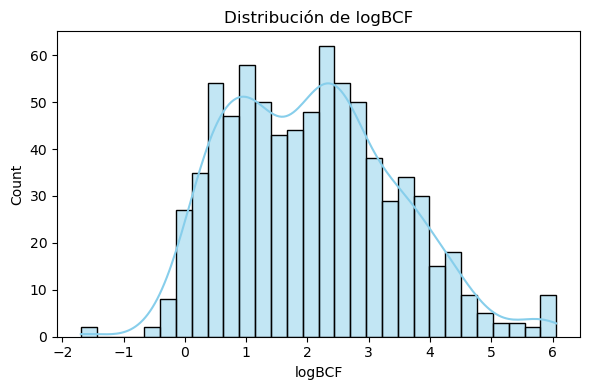

In [9]:
# Target
plt.figure(figsize=(6, 4))
sns.histplot(df["logBCF"], kde=True, bins=30, color="skyblue")
plt.title("Distribución de logBCF")
plt.xlabel("logBCF")
plt.tight_layout()
plt.show()

In [69]:
# Variables
# Normalizamos logBCF a [0, 1]
logBCF_min = df["logBCF"].min()
logBCF_max = df["logBCF"].max()
df["logBCF_norm"] = (df["logBCF"] - logBCF_min) / (logBCF_max - logBCF_min)

X = df.drop(columns=["CAS", "SMILES", "Set", "Class", "logBCF", "logBCF_norm"])
y = df["logBCF_norm"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_trainval = X_scaled[df["Set"] == "Train"]
y_trainval = y[df["Set"] == "Train"].values
X_test = X_scaled[df["Set"] == "Test"]
y_test_true = df[df["Set"] == "Test"]["logBCF"].values

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=13
)

In [83]:
# Red neuronal
class BCFRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.SiLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [86]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

model = BCFRegressor(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

best_val_loss = float("inf")
patience = 200
counter = 0
epochs = 1000

wandb.init(project="ch6_regression", entity="zerocris13")
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred_train = model(X_train_tensor)
    loss_train = criterion(y_pred_train, y_train_tensor)
    loss_train.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_tensor)
        loss_val = criterion(y_pred_val, y_val_tensor)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": loss_train.item(),
        "val_loss": loss_val.item()
    })

    if loss_val.item() < best_val_loss:
        best_val_loss = loss_val.item()
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss_train.item():.6f}, Val Loss: {loss_val.item():.6f}")


Epoch 50, Train Loss: 0.007941, Val Loss: 0.008793
Epoch 100, Train Loss: 0.007312, Val Loss: 0.008957
Epoch 150, Train Loss: 0.006412, Val Loss: 0.008654
Epoch 200, Train Loss: 0.006175, Val Loss: 0.008515
Epoch 250, Train Loss: 0.005947, Val Loss: 0.009141
Epoch 300, Train Loss: 0.005400, Val Loss: 0.008847
Epoch 350, Train Loss: 0.005493, Val Loss: 0.009017
Epoch 400, Train Loss: 0.005801, Val Loss: 0.008616
Epoch 450, Train Loss: 0.005576, Val Loss: 0.008362
Epoch 500, Train Loss: 0.005685, Val Loss: 0.008848
Epoch 550, Train Loss: 0.006127, Val Loss: 0.009230
Epoch 600, Train Loss: 0.005710, Val Loss: 0.009129
Epoch 650, Train Loss: 0.006084, Val Loss: 0.008641
Early stopping at epoch 657


In [87]:
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_tensor).numpy().flatten()

y_pred_logBCF = y_pred_norm * (logBCF_max - logBCF_min) + logBCF_min
mse = mean_squared_error(y_test_true, y_pred_logBCF)
r2 = r2_score(y_test_true, y_pred_logBCF)

print(f"MSE (logBCF): {mse:.4f}")
print(f"R² Score (logBCF): {r2:.4f}")
wandb.log({"test_mse": mse, "test_r2": r2})
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


MSE (logBCF): 0.4763
R² Score (logBCF): 0.7549


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇████
test_mse,▁
test_r2,▁
train_loss,▇█▇▅▄▃▃▄▃▃▂▃▂▂▂▁▃▂▂▂▂▁▂▃▁▂▂▁▂▃▂▁▂▂▂▂▂▂▂▂
val_loss,█▃▃▃▂▂▂▂▂▁▂▃▃▂▁▃▂▃▃▄▃▄▄▃▁▂▂▁▁▁▃▄▅▄▄▃▄▃▂▂
epoch,657
test_mse,0.47631
test_r2,0.7549
train_loss,0.00599
val_loss,0.00916


Se realizó un barrido de hiperparámetros en **Weights & Biases (W&B)** variando los siguientes parámetros: cantidad de capas (`layers`), tamaño de las capas ocultas (`hidden_dim`). Se evaluaron los modelos comparando el tiempo de entrenamiento (`train_time_sec`), el error cuadrático medio en test (`test_mse`) y el coeficiente de determinación (`test_r2`). 

Al comparar los resultados del sweep, se observa que el modelo **floral-sweep-2** (3 capas, 64 unidades ocultas, activación `silu`) obtuvo el mejor desempeño, con un `test_mse` de **0.566** y un `test_r2` de **0.7088**. En contraste, el peor desempeño fue alcanzado por **desert-sweep-4**, que usó la misma cantidad de capas (3) pero con 128 unidades ocultas, obteniendo un `test_mse` de **0.731** y un `test_r2` de **0.6238**. 

Esto sugiere que un mayor número de parámetros (como en el modelo con 128 unidades ocultas) no garantiza una mejor generalización. Es probable que este modelo haya sobreajustado los datos de entrenamiento (overfitting), lo cual se refleja en un mayor error en el conjunto de prueba. 

Además, es importante señalar que cuando se trabaja con pocos datos, es preferible optar por arquitecturas más simples para evitar el sobreajuste y obtener una mejor capacidad de generalización.

🔗 [Visualizar resultados en W&B](https://api.wandb.ai/links/zerocris13/uu5249ql)
